이름 : 김동현<br>
MBTI : ISFP<br>
저도 찍먹하려고 시작했는데, 
관심사 : 농구,야구, 드라마보기<br>
관심프로젝트는 없고, 다뤘던 예제에서 긍정리뷰 부정리뷰 


### 데이터 수집

In [1]:
import pandas as pd
data = pd.read_table('ck_data.txt', names = ['label','reviews'])
data

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
...,...,...
99995,0,한글화해주면 10개산다
99996,0,개쌉노잼 ㅋㅋ
99997,0,노잼이네요... 30분하고 지웠어요...
99998,1,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.


### 전처리

In [2]:
data.isnull().values.any()

False

In [3]:
data['label'].nunique(), data['reviews'].nunique()

(2, 99892)

In [4]:
t_l_0 = data[data.label==0]

In [5]:
data=data.rename(columns = {'label':'y', 'reviews' : 'X'})

In [6]:
import numpy as np
s_w=set(['은','는','이','가','를','들','에게','의','을','도','으로','만','라서','하다'])
data= data.drop_duplicates(subset=['X'])#중복제거
data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') 
data['clean_X']=data.clean_X.str.replace('^ +','')
data['clean_X']=data.clean_X.replace('',np.nan) 
data=data.dropna(how='any') 

C:\Users\82105\AppData\Local\Temp/ipykernel_11988/3868267648.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X']=data.X.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')#한글외 정리
C:\Users\82105\AppData\Local\Temp/ipykernel_11988/3868267648.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_X']=data.clean_X.str.replace('^ +','')#공백 시작문자 정리


In [7]:
from konlpy.tag import Okt
okt=Okt()
from tqdm import tqdm 
X_data=[] 
for i in tqdm(data['clean_X']): 
    tk_d=okt.morphs(i) 
    end_d=[w for w in tk_d if not w in s_w] 
    X_data.append(' '.join(end_d))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99892/99892 [02:31<00:00, 657.56it/s]


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

data['y_name']=data['y']
data['encoder_y']=LabelEncoder().fit_transform(data['y'])
data['categorical_y']=list(to_categorical(data['encoder_y']))
Y=np.array(data['encoder_y'])
X=np.array(X_data)
x_data,test_x,y_data,test_y = train_test_split(X,Y,test_size=0.3,random_state=0)
train_x,val_x,train_y,val_y = train_test_split(x_data,y_data,test_size=0.2,random_state=0)

In [9]:
(train_x.shape,train_y.shape),(test_x.shape,test_y.shape),(val_x.shape,val_y.shape)

(((55939,), (55939,)), ((29968,), (29968,)), ((13985,), (13985,)))

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(train_x)
n=len([d for d in sorted(list(tk.word_counts.items()),key=lambda x:x[1]) if d[1]>4])+1
token=Tokenizer(n)
token.fit_on_texts(train_x)
token_train_x=token.texts_to_sequences(train_x)
token_test_x=token.texts_to_sequences(test_x)
token_val_x=token.texts_to_sequences(val_x)
drop_train = [index for index, sentence in enumerate(token_train_x) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(token_test_x) if len(sentence) < 1] 
drop_val = [index for index, sentence in enumerate(token_val_x) if len(sentence) < 1] 
token_train_x = np.delete(token_train_x, drop_train, axis=0)
train_y = np.delete(train_y, drop_train, axis=0)
token_test_x = np.delete(token_test_x, drop_test, axis=0)
test_y = np.delete(test_y, drop_test, axis=0)
token_val_x = np.delete(token_val_x, drop_val, axis=0)
val_y = np.delete(val_y, drop_val, axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
w_l=len(pad_sequences(token_train_x)[0])
train_inputs = pad_sequences(token_train_x,maxlen=w_l)
test_inputs = pad_sequences(token_test_x,maxlen=w_l)
val_inputs = pad_sequences(token_val_x,maxlen=w_l)

In [12]:
train_outputs=train_y
test_outputs=test_y
val_outputs=val_y

In [13]:
(train_inputs.shape,train_outputs.shape),(test_inputs.shape,test_outputs.shape),(val_inputs.shape,val_outputs.shape)

(((55568, 53), (55568,)), ((29741, 53), (29741,)), ((13870, 53), (13870,)))

In [14]:
전처리된데이터={}
전처리된데이터['학습데이터'] = train_inputs
전처리된데이터['학습결과'] = train_outputs
전처리된데이터['테스트데이터'] = test_inputs
전처리된데이터['테스트결과'] = test_outputs
전처리된데이터['검증데이터'] = val_inputs
전처리된데이터['검증결과'] = val_outputs
전처리된데이터['토큰'] = token
전처리된데이터['단어수'] = n
전처리된데이터['불용어'] = s_w
전처리된데이터['입력길이'] = w_l

In [15]:
전처리된데이터.keys()

dict_keys(['학습데이터', '학습결과', '테스트데이터', '테스트결과', '검증데이터', '검증결과', '토큰', '단어수', '불용어', '입력길이'])

In [16]:
import pickle
with open("data.pickle", 'wb') as fw:
    pickle.dump(전처리된데이터, fw)

### 모델학습

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding, Dense, LSTM,BatchNormalization, Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_modelQ1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [18]:
model = Sequential()
model.add(Embedding(n, 128))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_inputs, train_outputs, epochs=10, callbacks=[es, mc], batch_size=32,validation_data=(val_inputs,val_outputs))

Epoch 1/10
1737/1737 [==============================] - 209s 117ms/step - loss: 0.5071 - acc: 0.7516 - val_loss: 0.4625 - val_acc: 0.7789

Epoch 00001: val_acc improved from -inf to 0.77895, saving model to best_modelQ1.h5
Epoch 2/10
1737/1737 [==============================] - 206s 119ms/step - loss: 0.3991 - acc: 0.8213 - val_loss: 0.4777 - val_acc: 0.7813

Epoch 00002: val_acc improved from 0.77895 to 0.78125, saving model to best_modelQ1.h5
Epoch 3/10
1737/1737 [==============================] - 209s 120ms/step - loss: 0.3300 - acc: 0.8561 - val_loss: 0.4910 - val_acc: 0.7792

Epoch 00003: val_acc did not improve from 0.78125
Epoch 4/10
1737/1737 [==============================] - 196s 113ms/step - loss: 0.2693 - acc: 0.8837 - val_loss: 0.5589 - val_acc: 0.7685

Epoch 00004: val_acc did not improve from 0.78125
Epoch 5/10
1737/1737 [==============================] - 196s 113ms/step - loss: 0.2177 - acc: 0.9097 - val_loss: 0.6940 - val_acc: 0.7627

Epoch 00005: val_acc did not impro

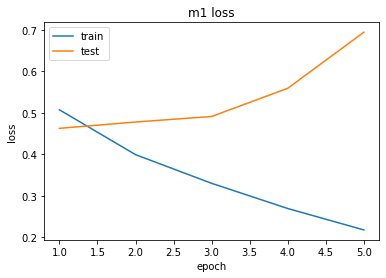

In [20]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('m1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
loaded_model = load_model('best_modelQ1.h5')
loaded_model.evaluate(test_inputs,test_outputs)[1]

930/930 [==============================] - 28s 29ms/step - loss: 0.4762 - acc: 0.7826


0.7825560569763184

In [23]:
import re
def 문장_전처리(문장):
    문장 = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', 문장)
    문장 = okt.morphs(문장, stem=True)
    문장 = [w for w in 문장 if not w in s_w] 
    encoded = token.texts_to_sequences([문장])
    pad_new = pad_sequences(encoded, maxlen = w_l) 
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 긍정 리뷰입니다.\n")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 부정 리뷰입니다.\n")

In [24]:
문장_전처리('쓰레기 같은 게임')

93.87% 확률로 부정 리뷰입니다.



In [25]:
문장_전처리('재밌게 플레이 했습니다')

95.26% 확률로 긍정 리뷰입니다.



### 보충했으면 하는 부분

크롤링,